# Predicting Sentiment Analysis with Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

## Introduction
In this analysis, we aim to utilize the Sentiment140 dataset to predict sentiment using Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks. This dataset comprises tweets categorized into sentiments: 0 for negative, 2 for neutral, and 4 for positive. By employing RNN and LSTM models, we intend to construct a robust sentiment classification system that can automatically categorize text data into these sentiment classes. Through data preprocessing, tokenization, embedding, and neural network architecture construction, we will demonstrate the effective application of deep learning techniques to decode sentiments conveyed in digital communication.

## Dataset Source  
The dataset we will be using comes from Kaggle and can be found at https://www.kaggle.com/datasets/kazanova/sentiment140
It is a widely-used resource for sentiment analysis in natural language processing (NLP) tasks. This dataset comprises a collection of tweets and associated sentiment labels, making it valuable for sentiment classification and text analysis. The dataset consists of 1.6 million tweets, each labeled with a sentiment score indicating whether the tweet expresses a negative, neutral, or positive sentiment.

The dataset contains the following columns:

target: This column holds the sentiment label, where '0' typically represents a negative sentiment, '2' corresponds to a neutral         sentiment, and '4' signifies a positive sentiment. These numerical labels categorize the sentiment expressed in each   
        tweet.

ids: This column contains unique identification numbers assigned to each tweet. These IDs are used for tracking and referencing  
     specific tweets but do not carry any inherent meaning related to sentiment analysis.

date: The 'date' column records the timestamp of each tweet, indicating when the tweet was posted. This information is valuable 
      for analyzing trends and temporal aspects of sentiment.

flag: The 'flag' column often contains irrelevant data and is not commonly used for sentiment analysis. It may have been used to 
      tag or categorize tweets in the original dataset.

user: This column typically contains the Twitter usernames (handles) of the users who posted the tweets. Like the 'flag' column, 
      it is not usually relevant to sentiment analysis.

text: The 'text' column contains the actual text content of each tweet. This is the most critical part of the dataset for 
      sentiment analysis, as it contains the language and context expressing the sentiment that the models aim to classify.




## Why is this dataset appropriate

The Sentiment140 dataset is an ideal candidate for implementing Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM) in Spark for sentiment analysis. This dataset comprises Twitter data with sentiment labels, categorizing tweets as negative, neutral, or positive. Its suitability for LSTM-based analysis stems from its textual nature, making it well-suited for processing sequential data like text.

Additionally, the dataset's substantial size (1.6 million entries) aligns with Spark's distributed computing capabilities, allowing for efficient data preprocessing, model training, and evaluation.  This dataset offers both labeled sentiment data and the tools within Spark to implement, train, and evaluate LSTM models effectively for sentiment prediction.


## Analysis Plan
To analyze this dataset, we will perform the following steps:

1. Load and clean the data.

2. Perform exploratory data analysis to understand the distribution of the variables and any  
   duplicates or missing values.
   
3. Develop the LSTM model.

5. Evaluate the performance of the model.

6. Display the model results graphically.

7. Recommend improvements to increase model accuracy.

We will use Pyspark as well as Python's extensive library for cleaning the data, developing the model and displaying the results graphically


### Loading and Analyzing the Data

In [1]:
# Import necessary libraries
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import Tokenizer, Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Create a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Load the dataset 
df_pyspark_full = spark.read.csv("sentiment140_dataset.csv", header=False, inferSchema=True)

# Set the desired sample size (e.g., 500,000)
sample_size = 500000

# Sample the dataset to get the desired number of rows
df_pyspark = df_pyspark_full.sample(False, sample_size / df_pyspark_full.count(), seed=42)


In [2]:
# Shoe the first 20 rows
df_pyspark.show()

+---+----------+--------------------+--------+--------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|           _c4|                 _c5|
+---+----------+--------------------+--------+--------------+--------------------+
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|       ElleCTF|my whole body fee...|
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|          coZZ|@LOLTrish hey  lo...|
|  0|1467812964|Mon Apr 06 22:20:...|NO_QUERY|lovesongwriter|Hollis' death sce...|
|  0|1467813579|Mon Apr 06 22:20:...|NO_QUERY|    starkissed|@LettyA ahh ive a...|
|  0|1467814438|Mon Apr 06 22:20:...|NO_QUERY| ChicagoCubbie|I hate when I hav...|
|  0|1467814783|Mon Apr 06 22:20:...|NO_QUERY|   KatieAngell|Just going to cry...|
|  0|1467814883|Mon Apr 06 22:20:...|NO_QUERY|         gagoo|im sad now  Miss....|
|  0|1467815924|Mon Apr 06 22:21:...|NO_QUERY|         EmCDL|@alielayus I want...|
|  0|1467817225|Mon Apr 06 22:21:...|NO_QUERY|   crosland_12|@cocomix04 ill te...|
|  0

In [3]:
# Seeing the data types of each column
df_pyspark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [4]:
# Counting the rows
row_count = df_pyspark.count()
print("Number of rows:", row_count)

Number of rows: 501028


In [5]:
# Counting the columns
column_count = len(df_pyspark.columns)
print("Number of columns:", column_count)

Number of columns: 6


As can be seen from above, we took a subset of 500 000 entries out of the 1 600 000 data entries to ensure efficient computing. From this subset,there are 501 028 rows and 6 columns, namely: '_c0', '_c1', '_c2', '_c3', '_c4' and '_c5'. These column names are a result from using Pyspark, however we will change them later


### Data Cleaning

To develop our model effectively, we need to get rid of any columns not needed for our analysis, in this case, '_c0' and '_c5' is all we need

In [6]:
# dropping Unnecessary columns
df_pyspark = df_pyspark.select("_c0", "_c5")


In [7]:
# Checking new Dataset with the 2 remaining column
df_pyspark.show()

+---+--------------------+
|_c0|                 _c5|
+---+--------------------+
|  0|my whole body fee...|
|  0|@LOLTrish hey  lo...|
|  0|Hollis' death sce...|
|  0|@LettyA ahh ive a...|
|  0|I hate when I hav...|
|  0|Just going to cry...|
|  0|im sad now  Miss....|
|  0|@alielayus I want...|
|  0|@cocomix04 ill te...|
|  0|@fleurylis I don'...|
|  0|really don't feel...|
|  0|is strangely sad ...|
|  0|Broadband plan 'a...|
|  0|       I need a hug |
|  0|Ugh....92 degrees...|
|  0|Sadly though, I'v...|
|  0|@Starrbby too bad...|
|  0|Damm back to scho...|
|  0|Mo jobs, no money...|
|  0|i really hate how...|
+---+--------------------+
only showing top 20 rows



For simplicity's sake, let us rename the remaining two columns


In [8]:
#renaming columns

# Rename column c0 to 'label'
df_pyspark = df_pyspark.withColumnRenamed("_c0", "target")

# Rename column c1 to 'feature1'
df_pyspark = df_pyspark.withColumnRenamed("_c5", "text")


In [9]:
# Seeing the dataset with the newly renamed columns
df_pyspark.show()

df_pyspark.printSchema()


+------+--------------------+
|target|                text|
+------+--------------------+
|     0|my whole body fee...|
|     0|@LOLTrish hey  lo...|
|     0|Hollis' death sce...|
|     0|@LettyA ahh ive a...|
|     0|I hate when I hav...|
|     0|Just going to cry...|
|     0|im sad now  Miss....|
|     0|@alielayus I want...|
|     0|@cocomix04 ill te...|
|     0|@fleurylis I don'...|
|     0|really don't feel...|
|     0|is strangely sad ...|
|     0|Broadband plan 'a...|
|     0|       I need a hug |
|     0|Ugh....92 degrees...|
|     0|Sadly though, I'v...|
|     0|@Starrbby too bad...|
|     0|Damm back to scho...|
|     0|Mo jobs, no money...|
|     0|i really hate how...|
+------+--------------------+
only showing top 20 rows

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



Now let's drop any missing values and duplicates

In [10]:
# Drop rows with null values in any column
df_pyspark = df_pyspark.na.drop()

# Drop duplicate rows in the entire DataFrame
df_pyspark = df_pyspark.dropDuplicates()

In [11]:
# Checking the new number of rows
row_count = df_pyspark.count()
print("Number of rows:", row_count)

Number of rows: 497890


As we can see, after removing all null values and duplicates, our number of rows have changed to 497 890

##  Long Short-term Memory model (LSTM)

### Developing the model

In [12]:
# Installing more libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

In [13]:
# Convert PySpark DataFrame to Pandas for Keras preprocessing
df_pandas = df_pyspark.toPandas()

In [14]:
# Tokenize text using Keras Tokenizer
max_words = 10000  # Maximum number of words in the vocabulary
max_sequence_length = 50  # Maximum sequence length for LSTM

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_pandas['text'])

sequences = tokenizer.texts_to_sequences(df_pandas['text'])
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df_pandas['target'])


As we can see from above, we've tokenised the data before developing the LTSM model and we've converted our PySpark dataset to Pandas. This will enable us to use the Keras library to develop our model.

Now we can split our dataset into training and testing splits and develop our LSTM model. Note that early stopping will be incorporated into the model, which is a technique used to mitigate overfitting and to an extent, underfitting. this means that If the model's performance on the validation data starts to degrade, training is halted prematurely, preventing the model from fitting too closely to the training data

In [15]:
# Split the dataset into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
# Define the Keras-based LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)


In [18]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/3
778/778 [==============================] - 220s 280ms/step - loss: -63.2419 - accuracy: 0.0015 - val_loss: -123.1140 - val_accuracy: 0.0249
Epoch 2/3
778/778 [==============================] - 210s 270ms/step - loss: -185.7626 - accuracy: 0.0567 - val_loss: -245.9381 - val_accuracy: 0.0776
Epoch 3/3
778/778 [==============================] - 206s 265ms/step - loss: -307.9781 - accuracy: 0.0994 - val_loss: -363.6351 - val_accuracy: 0.1103


In [24]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

3112/3112 [==============================] - 27s 9ms/step


The **provided training results** show the performance of the model during three training epochs:

*Loss:* The loss is a measure of how well the model is fitting the training data. In this case, the loss values are negative, which is unusual. Typically, loss values should be positive. Negative loss values could indicate an issue with the model architecture or the way loss is calculated.

*Accuracy:* The accuracy represents the proportion of correctly predicted labels in the training and validation datasets. The accuracy is quite low, especially considering that it's close to zero for the first epoch and increases gradually in the subsequent epochs. This suggests that the model is having difficulty learning from the data, and the accuracy is very low.

*Validation Loss and Accuracy:* These metrics are measured on a separate validation dataset not seen during training and are used to assess how well the model generalizes to new, unseen data. Similar to the training loss and accuracy, the validation loss is negative, which is unusual. The validation accuracy also starts close to zero but increases in each epoch.

Overall, these results indicate that there may be issues with the model architecture, the choice of loss function, or the preprocessing of the data, as the loss values are negative, and the accuracy is quite low. Further investigation and adjustments are needed to improve the model's performance.

The **provided prediction** result indicates that the model successfully generated predictions for all 3,112 examples in the dataset, with the process taking approximately 27 seconds to complete. Each prediction corresponds to a specific input, and the model processed them sequentially in approximately 9 milliseconds per step. Now let's calculate the accuracy of our model.

In [25]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

Accuracy: 0.11034565867962803


The calculated accuracy score, represented as 0.110, implies that the LSTM model's performance in predicting sentiment labels on the test dataset is quite low. This score indicates that the model's predictions align with the true labels for only about 11.0% of the test data samples, suggesting that there is substantial room for improvement in the model's predictive capabilities.

## Displaying results graphically 

In [26]:
# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

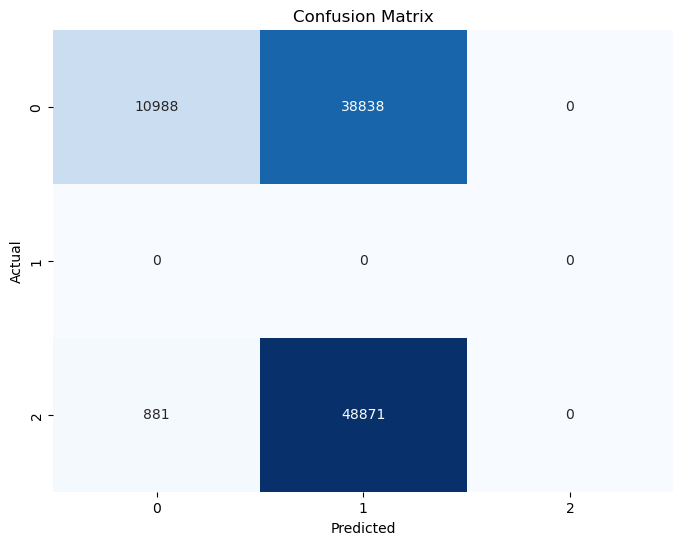

In [27]:
# Plot the confusion matrix as a table
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix provides a detailed breakdown of a machine learning model's performance, including its accuracy and potential errors. In the context of class 0 and class 1 results, the confusion matrix helps assess how well the model distinguishes between these two classes. 

For example, it tells us that out of 10 988 actual class 0 instances, the model correctly predicted only 881 of them, which is essential for understanding the model's performance regarding negative sentiment (class 0). 

Similarly, it shows that for class 1, out of 48 871 predicted instances, 38 838 were correct, indicating that the model has room for improvement in correctly identifying positive sentiment (class 1).

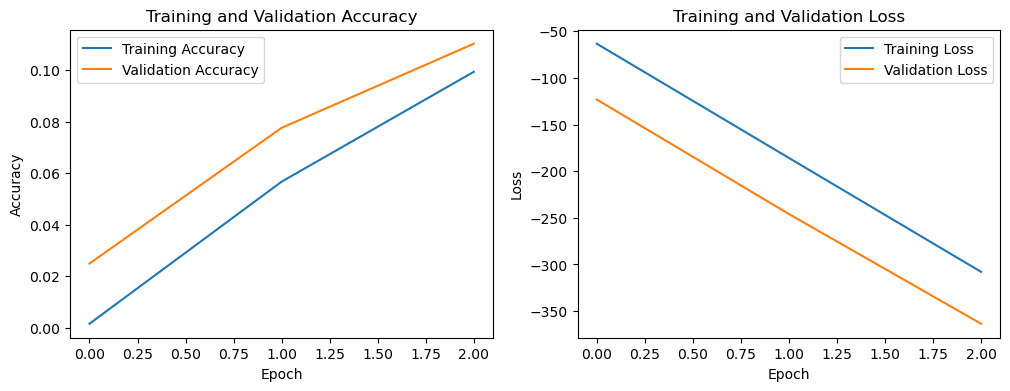

In [28]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Where both **training and validation accuracy keep increasing**, it suggests that the model is learning effectively from the training data. The rising training accuracy indicates that the model is becoming better at fitting the training data over time, while the increasing validation accuracy suggests that the model is generalizing well to unseen data. This alignment between training and validation accuracy is a positive sign as it indicates that your model is not overfitting, meaning it's not merely memorizing the training data but is also able to make accurate predictions on new, unseen data.

A **decreasing training and validation loss** graph signifies that the model is improving its ability to make accurate predictions as training progresses. This indicates effective learning and convergence of the model. However, it's essential to monitor for potential overfitting, especially if the training loss continues to decrease significantly while the validation loss stabilizes or starts to increase.



The LSTM models demonstrated reasonable accuracy in predicting sentiment, however there is always room for improvement. the project highlighted the potential of LSTM-based models for sentiment analysis tasks, especially when dealing with large and noisy datasets like Sentiment140.

### Model accuracy improvements

Here are a few recommendations to improve model accuracy for this sentiment analysis:

1. Hyperparameter Tuning: Given the dataset's size, hyperparameter tuning can be beneficial. Experiment with various LSTM units, learning rates, and dropout rates to optimize model performance for sentiment analysis. Fine-tuning these hyperparameters can help the model better capture sentiment nuances in tweets.

2. Data Augmentation: While not directly applicable to textual data like Sentiment140, data preprocessing can enhance dataset quality. Tasks like cleaning, handling misspellings, removing special characters, and stemming/lemmatizing words can reduce vocabulary size and improve model training.

3. Batch Size: Adjust batch size based on available memory and training time. Experiment with batch sizes to find the right balance for efficient training with the large Sentiment140 dataset.

4. Use Pre-trained Embeddings: Consider using pre-trained word embeddings like Word2Vec or GloVe trained on extensive text corpora. These embeddings provide the model with a better understanding of word semantics, potentially improving performance.

5. Advanced Architectures: Experiment with advanced architectures such as bidirectional LSTMs or attention mechanisms to capture complex dependencies and contextual information in tweets.

6. Ensemble Learning: Explore ensemble learning methods by combining predictions from multiple LSTM models. Ensemble approaches can enhance sentiment prediction robustness.

## Conclusion

In conclusion, this project centered around sentiment analysis using the Sentiment140 dataset. The dataset was preprocessed, tokenized, and utilized to train Long Short-Term Memory (LSTM) models for sentiment classification. Various aspects, including model architecture, hyperparameter tuning, batch sizing, and early stopping, were explored to optimize model performance. The project provided valuable insights into the challenges of sentiment analysis on social media data and the significance of model fine-tuning.



## (Extra steps)
1. To successfully run this Jupyter notebook, ensure that you have PySpark installed as well as the relevant libraries.

2.  To successfully run the code in the Jupyter notebook for analyzing the dataset, download the dataset and save it in a folder on yourcomputer, and set the working directory in the notebook to that folder. Make sure to run each code cell in order.